# Домашнее задание 2 по обработке текстов

Рассмотрим задачу бинарной классификации. Пусть дано два списка имен: мужские и женские имена. Требуется разработать классификатор, который по данному имени будет определять мужское оно или женское.

Данные: 
* Женские имена: female.txt
* Мужские имена: male.txt

In [1]:
# plots
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%pylab inline
%config InlineBackend.figure_format = 'png'
rcParams['figure.figsize'] = (16, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
! ls

female.txt  male.txt    names.ipynb


In [2]:
import pandas as pd
import numpy as np

## Часть 1. Предварительная обработка данных

1. Удалите неоднозначные имена (те имена, которые являются и мужскими, и женскими дновременно), если такие есть; 
2. Создайте обучающее и тестовое множество так, чтобы в обучающем множестве классы были сбалансированы, т.е. к классу принадлежало бы одинаковое количество имен;

In [3]:
df_male = pd.read_csv('male.txt', sep=",", header=None, names=['name'])
display(df_male.head(), df_male.describe(), df_male.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943 entries, 0 to 2942
Data columns (total 1 columns):
name    2943 non-null object
dtypes: object(1)
memory usage: 23.1+ KB


,name
0,Aamir
1,Aaron
2,Abbey
3,Abbie
4,Abbot


,name
count,2943
unique,2943
top,Hakeem
freq,1


None

In [4]:
df_female = pd.read_csv('female.txt', sep=",", header=None, names=['name'])
display(df_female.head(), df_female.describe(), df_female.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 1 columns):
name    5001 non-null object
dtypes: object(1)
memory usage: 39.1+ KB


,name
0,Abagael
1,Abagail
2,Abbe
3,Abbey
4,Abbi


,name
count,5001
unique,5001
top,Valaria
freq,1


None

In [5]:
df_male['male'] = 1
df_female['male'] = 0
df_all = df_male.append(df_female)
df_all['name'] = df_all['name'].str.lower()
df_all.drop_duplicates(subset=['name'], inplace=True, keep=False)
display(df_all.head(), df_all.describe(), df_all.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7208 entries, 0 to 5000
Data columns (total 2 columns):
name    7208 non-null object
male    7208 non-null int64
dtypes: int64(1), object(1)
memory usage: 168.9+ KB


,name,male
0,aamir,1
1,aaron,1
4,abbot,1
5,abbott,1
7,abdel,1


,male
count,7208.000000
mean,0.357658
std,0.479344
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


None

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
df_train, df_test = train_test_split(df_all, test_size=0.2, random_state=42, stratify=df_all['male'])
df_train.reset_index(inplace = True, drop = True)
df_test.reset_index(inplace = True, drop = True)
display(df_train["male"].value_counts(), df_test["male"].value_counts())

0    3704
1    2062
Name: male, dtype: int64

0    926
1    516
Name: male, dtype: int64

##  Часть 2. Базовый метод классификации

Используйте метод наивного Байеса или логистическую регрессию для классификации имен: в качестве признаков используйте символьные $n$-граммы. Сравните результаты, получаемые при разных $n=2,3,4$ по $F$-мере и аккуратности. В каких случаях метод ошибается?

Для генерации $n$-грамм используйте:

In [ ]:
# from nltk.util import ngrams

In [8]:
from sklearn.metrics import *

def print_score(y_test, y_pred):
    print("Accuracy:    {0:.2f}".format(accuracy_score(y_test, y_pred)))  
    print("F1-measure:  {0:.2f}".format(f1_score(y_test, y_pred, average='macro')))
    print("Precision:   {0:.2f}".format(precision_score(y_test, y_pred)))
    print("Recall:      {0:.2f}".format(recall_score(y_test, y_pred)))
    
    print(classification_report(y_test, y_pred, target_names=['female', 'male']))

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [10]:
clf = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char_wb')),
    ('tfidf', TfidfTransformer()),    
    ('clf', MultinomialNB()),
])

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [12]:
params = {
    'vectorizer__ngram_range': [(1, 1), (1, 3), (2, 2), (2, 3), (2, 4)],
    'tfidf__use_idf': (True, False),    
    'clf__alpha': (0.001, 0.01, 0.1, 1)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = GridSearchCV(clf, params, scoring='f1', cv=cv, n_jobs=-1)
clf.fit(df_train['name'], df_train['male'])

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
    ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__alpha': (0.001, 0.01, 0.1, 1), 'vectorizer__ngram_range': [(1, 1), (1, 3), (2, 2), (2, 3), (2, 4)], 'tfidf__use_idf': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [13]:
predictions = clf.best_estimator_.predict(df_test.name)
print_score(df_test['male'].values, predictions)

Accuracy:    0.90
F1-measure:  0.89
Precision:   0.92
Recall:      0.80
             precision    recall  f1-score   support

     female       0.90      0.96      0.93       926
       male       0.92      0.80      0.85       516

avg / total       0.90      0.90      0.90      1442



##  Часть 3. Нейронная сеть


Используйте  реккурентную нейронную сеть с  LSTM для решения задачи. В ней может быть несколько слоев с LSTM, несколько слоев c Bidirectional(LSTM).  У нейронной сети один выход, определяющий класс имени. 

Представление имени для классификации в этом случае: бинарная матрица размера (количество букв в алфавите $\times$ максимальная длина имени). Обозначим его через $x$. Если первая буква имени a, то $x[1][1] = 1$, если вторая – b, то  $x[2][1] = 1$.  

Не забудьте про регуляризацию нейронной сети дропаутами. 

Сравните результаты классификации разными методами. Какой метод лучше и почему?

Сравните результаты, получаемые при разных значениях дропаута, разных числах узлов на слоях нейронной сети по $F$-мере и аккуратности. В каких случаях нейронная сеть ошибается?

Если совсем не получается запрограммировать нейронную сеть самостоятельно, обратитесь к туториалу тут: https://github.com/divamgupta/lstm-gender-predictor

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Bidirectional
from keras.layers import LSTM
from keras.utils import to_categorical

Using TensorFlow backend.


In [15]:
longest_name_length = df_all['name'].str.len().max()

chars = sorted(list(set("".join(df_train['name']))))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

X_train = np.zeros((len(df_train), longest_name_length, len(chars)), dtype=np.int)
y_train = np.zeros((len(df_train), 1), dtype=np.int)

for i in range(len(df_train)):    
    for t, char in enumerate(df_train['name'][i]):
        X_train[i, t, char_indices[char]] = 1
    y_train[i] = df_train['male'][i]

X_test = np.zeros((len(df_test), longest_name_length, len(chars)), dtype=np.int)
y_test = np.zeros((len(df_test), 1), dtype=np.int)

for i in range(len(df_test)):    
    for t, char in enumerate(df_test['name'][i]):        
        X_test[i, t, char_indices[char]] = 1
    y_test[i] = df_test['male'][i]
    
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

total chars: 29
(5766, 15, 29) (5766, 1) (1442, 15, 29) (1442, 1)


In [32]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(longest_name_length, len(chars))))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

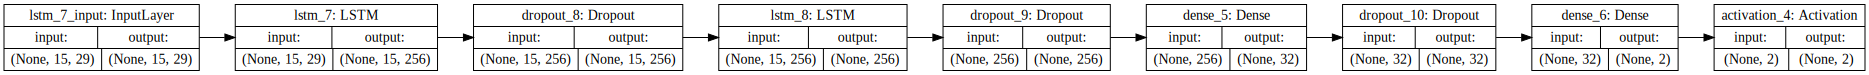

In [33]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, rankdir='LR').create(prog='dot', format='svg'))

In [34]:
model.fit(X_train, y_train, batch_size=16, epochs=30)

Epoch 1/30
5766/5766 [==============================] - 19s 3ms/step - loss: 0.5398 - acc: 0.7385
Epoch 2/30
5766/5766 [==============================] - 16s 3ms/step - loss: 0.4815 - acc: 0.7790
Epoch 3/30
5766/5766 [==============================] - 17s 3ms/step - loss: 0.4551 - acc: 0.7896
Epoch 4/30
5766/5766 [==============================] - 17s 3ms/step - loss: 0.4369 - acc: 0.8054
Epoch 5/30
5766/5766 [==============================] - 17s 3ms/step - loss: 0.4120 - acc: 0.8146
Epoch 6/30
5766/5766 [==============================] - 16s 3ms/step - loss: 0.3951 - acc: 0.8255
Epoch 7/30
5766/5766 [==============================] - 16s 3ms/step - loss: 0.3714 - acc: 0.8368
Epoch 8/30
5766/5766 [==============================] - 16s 3ms/step - loss: 0.3578 - acc: 0.8408
Epoch 9/30
5766/5766 [==============================] - 17s 3ms/step - loss: 0.3460 - acc: 0.8535
Epoch 10/30
5766/5766 [==============================] - 16s 3ms/step - loss: 0.3340 - acc: 0.8599
Epoch 11/30
5766/57

In [35]:
y_pred = model.predict_classes(X_test)
print_score(y_test, y_pred)

Accuracy:    0.88
F1-measure:  0.87
Precision:   0.81
Recall:      0.84
             precision    recall  f1-score   support

     female       0.91      0.89      0.90       926
       male       0.81      0.84      0.83       516

avg / total       0.88      0.88      0.88      1442

